In [1]:
!unzip GTdb_crop.zip -d data # unzip the downloaded dataset

Archive:  GTdb_crop.zip
  inflating: data/cropped_faces/s01_01.jpg  
  inflating: data/cropped_faces/s01_02.jpg  
  inflating: data/cropped_faces/s01_03.jpg  
  inflating: data/cropped_faces/s01_04.jpg  
  inflating: data/cropped_faces/s01_05.jpg  
  inflating: data/cropped_faces/s01_06.jpg  
  inflating: data/cropped_faces/s01_07.jpg  
  inflating: data/cropped_faces/s01_08.jpg  
  inflating: data/cropped_faces/s01_09.jpg  
  inflating: data/cropped_faces/s01_10.jpg  
  inflating: data/cropped_faces/s01_11.jpg  
  inflating: data/cropped_faces/s01_12.jpg  
  inflating: data/cropped_faces/s01_13.jpg  
  inflating: data/cropped_faces/s01_14.jpg  
  inflating: data/cropped_faces/s01_15.jpg  
  inflating: data/cropped_faces/s02_01.jpg  
  inflating: data/cropped_faces/s02_02.jpg  
  inflating: data/cropped_faces/s02_03.jpg  
  inflating: data/cropped_faces/s02_04.jpg  
  inflating: data/cropped_faces/s02_05.jpg  
  inflating: data/cropped_faces/s02_06.jpg  
  inflating: data/cropped_faces

In [2]:
import os
import shutil
import random
import numpy as np
import cv2
from PIL import Image


import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D

from tensorflow.keras.utils import plot_model

from tensorflow.keras.saving import save_model
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing import image

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc

print(tf.version.VERSION)

2.12.0


In [3]:
# Define paths
original_dir = '/content/data/cropped_faces'
train_dir = '/content/process_data/train'
val_dir = '/content/process_data/validation'
test_dir = '/content/process_data/test'

# Create train and validation folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the number of images to put in each split
train_count = 7
val_count = 3
test_count = 5

# Loop through each person
for i in range(1, 51):
    person = "s{:02d}".format(i)
    
    # Create subdirectories for the person in each split
    os.makedirs(os.path.join(train_dir, person), exist_ok=True)
    os.makedirs(os.path.join(val_dir, person), exist_ok=True)
    os.makedirs(os.path.join(test_dir, person), exist_ok=True)
    
    # Loop through each image for the person and copy it to the appropriate split
    for j in range(1, 16):
        image_name = "{}_{:02d}.jpg".format(person, j)
        source_path = os.path.join(original_dir, image_name)
        
        if j <= train_count:
            dest_path = os.path.join(train_dir, person, image_name)
        elif j <= train_count + val_count:
            dest_path = os.path.join(val_dir, person, image_name)
        else:
            dest_path = os.path.join(test_dir, person, image_name)
        
        shutil.copy(source_path, dest_path)

In [ ]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # rotate images by up to 20 degrees
    width_shift_range=0.2,  # shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # shift images vertically by up to 20% of the image height
    shear_range=0.2,  # apply shear transformation with a shear angle of up to 20 degrees
    zoom_range=0.2,  # apply zoom transformation by up to 20%
    horizontal_flip=True,  # flip images horizontally
    fill_mode='nearest'  # fill any gaps created by the above transformations with the nearest pixel
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # rotate images by up to 20 degrees
    width_shift_range=0.2,  # shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # shift images vertically by up to 20% of the image height
    shear_range=0.2,  # apply shear transformation with a shear angle of up to 20 degrees
    zoom_range=0.2,  # apply zoom transformation by up to 20%
    horizontal_flip=True,  # flip images horizontally
    fill_mode='nearest'  # fill any gaps created by the above transformations with the nearest pixel
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (227,227),
    batch_size=64,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (227,227),
    batch_size=64,
    class_mode='categorical')

Found 350 images belonging to 50 classes.
Found 150 images belonging to 50 classes.


In [4]:
# Load VGG19 model without top layers
base_model = VGG19(weights='imagenet', include_top=False)

# Add top layers
x = base_model.output
x1 = GlobalAveragePooling2D()(x)
x2 = Dense(4096, activation='relu')(x1) # Keep the fully connected layer with 4096 units
x3 = Dense(4096, activation='relu')(x2) # Keep the fully connected layer with 4096 units
predictions = Dense(50, activation='softmax')(x3) # Change to 50 units for 50-class classifier

# Create a new model with the added top layers
model_1 = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_1.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
# Train the model
history_1 = model_1.fit(
    train_generator,
    epochs=20,  # specify the number of epochs for training
    validation_data=val_generator
)

Epoch 1/20
6/6 [==============================] - 412s 72s/step - loss: 4.5649 - accuracy: 0.0171 - val_loss: 3.9379 - val_accuracy: 0.0400
Epoch 2/20
6/6 [==============================] - 412s 72s/step - loss: 3.9611 - accuracy: 0.0229 - val_loss: 3.9044 - val_accuracy: 0.0533
Epoch 3/20
6/6 [==============================] - 419s 79s/step - loss: 3.9117 - accuracy: 0.0171 - val_loss: 3.8924 - val_accuracy: 0.0333
Epoch 4/20
6/6 [==============================] - 411s 72s/step - loss: 3.8866 - accuracy: 0.0371 - val_loss: 3.8609 - val_accuracy: 0.0333
Epoch 5/20
6/6 [==============================] - 411s 72s/step - loss: 3.8420 - accuracy: 0.0743 - val_loss: 3.8042 - val_accuracy: 0.0733
Epoch 6/20
6/6 [==============================] - 416s 72s/step - loss: 3.7698 - accuracy: 0.0600 - val_loss: 3.7550 - val_accuracy: 0.0533
Epoch 7/20
6/6 [==============================] - 416s 73s/step - loss: 3.6302 - accuracy: 0.0971 - val_loss: 3.5542 - val_accuracy: 0.1067
Epoch 8/20
6/6 [====

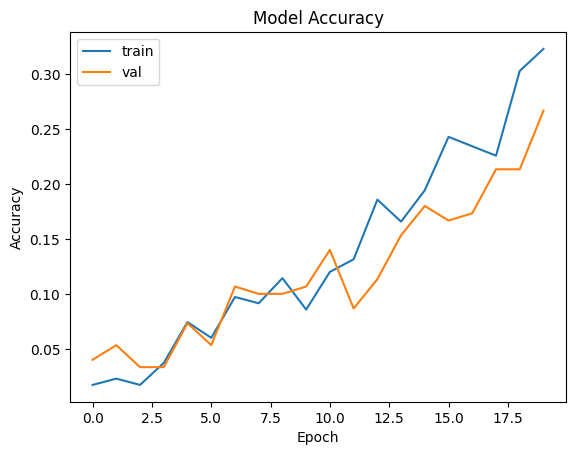

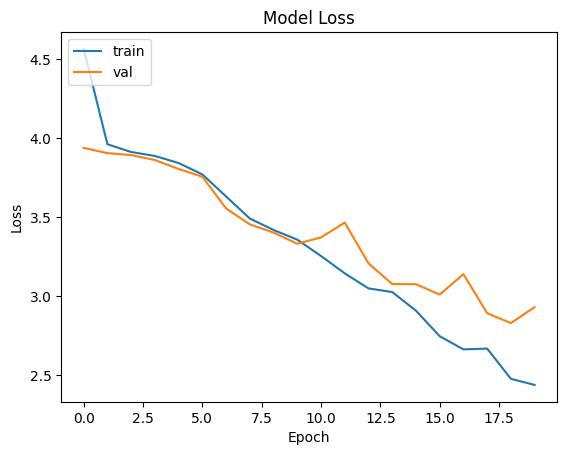

In [ ]:
# Plot the training and validation accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_1.save_weights('model_1_weights.h5')

In [ ]:
model_1.save('model_1.h5')

In [5]:
# Load the model from the H5 file
model_1.load_weights('/content/model_1_weights.h5')

In [6]:
# Create a new model that outputs the fc7 features
fc7_layer = model_1.get_layer('dense_1')
fc7_output = fc7_layer.output
model_1_withoudHead = Model(inputs=model_1.input, outputs=fc7_output)

In [7]:
# Define the paths to the validation dataset
test_dir = '/content/process_data/test'

# Define the batch size for validation data
batch_size = 1

# Create an empty list to hold the feature vectors for the validation images
test_features = []

# Loop through the validation image directories
for folder_name in os.listdir(test_dir):

    test_directory = os.path.join(test_dir, folder_name)

    # Create an empty list to hold the feature vectors for the validation images in the current directory
    directory_features = []
    
    # Loop through the validation images in the current directory
    for i in range(11, 16):
        # Load the validation image using PIL
        img_path = os.path.join(test_directory, f'{folder_name}_{i}.jpg')
        img = image.load_img(img_path, target_size=(227, 227))
        
        # Convert the image to a numpy array and preprocess it
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        # Extract the features using the VGG19 model
        features = model_1_withoudHead.predict(x)
        
        # Add the features to the list of features for the current directory
        directory_features.append(features.flatten())
    
    # Convert the list of features for the current directory to a numpy array
    directory_features = np.array(directory_features)
    
    # Add the numpy array to the list of feature vectors for all validation images
    test_features.append(directory_features)

# Convert the list of feature vectors for all validation images to a numpy array
test_features = np.array(test_features)
print(test_features)

1/1 [==============================] - 1s 621ms/step
[[[ 0.        14.139654   2.4502354 ...  0.         0.         0.       ]
  [ 0.        12.290299   2.2040577 ...  0.         0.         0.       ]
  [ 0.        11.337109   3.6494446 ...  0.         0.         0.       ]
  [ 0.         9.529051   1.8174248 ...  0.         0.         0.       ]
  [ 0.        12.327253   2.29327   ...  0.         0.         0.       ]]

 [[ 0.        12.937393   2.1804833 ...  0.         0.         0.       ]
  [ 0.        17.155766   4.6214356 ...  0.         0.         0.       ]
  [ 0.        15.967076   5.600358  ...  0.         0.         0.       ]
  [ 0.        15.440191   5.507016  ...  0.         0.         0.       ]
  [ 0.        13.943959   3.382998  ...  0.         0.         0.       ]]

 [[ 0.        10.918902   2.3112633 ...  0.         0.         0.       ]
  [ 0.        12.825713   4.763537  ...  0.         0.         0.       ]
  [ 0.        11.063464   3.4241288 ...  0.         0. 

In [8]:
print(test_features.shape)

(50, 5, 4096)


In [9]:
# Create a list for enrollment features for all subjects
enrollment_features = [[0] * 4096 for i in range(50)]

# Create a list for verification features for all subjects and each verification image
verification_features = [[[0] * 4096 for k in range(4)] for j in range(50)]

# Populate the enrollment_features list
for i in range(0,50):
    enrollment_features[i] = test_features[i][0]

# Populate the verification_features list
for j in range(0,50):
    verification_features[j][0] = test_features[j][1]
    verification_features[j][1] = test_features[j][2]
    verification_features[j][2] = test_features[j][3]
    verification_features[j][3] = test_features[j][4]

# Create a numpy array to store the cosine similarities
cosine_similarities = np.zeros((10000, 2))

# Iterate over each person and their enrollment and verification images
for i in range(0,50):
    a = 200 * i
    for j in range(0,50):
        b = a + (4 * j)
        
        # Get the enrollment feature and the four verification features
        enrollment_features_2d = enrollment_features[i].reshape(1, -1)
        verification_features_1_2d = verification_features[j][0].reshape(1, -1)
        verification_features_2_2d = verification_features[j][1].reshape(1, -1)
        verification_features_3_2d = verification_features[j][2].reshape(1, -1)
        verification_features_4_2d = verification_features[j][3].reshape(1, -1)
        # Calculate the cosine similarity between the enrollment and verification features
        cosine_similarities[b][0] = cosine_similarity(enrollment_features_2d, verification_features_1_2d)
        cosine_similarities[b+1][0] = cosine_similarity(enrollment_features_2d, verification_features_2_2d)
        cosine_similarities[b+2][0] = cosine_similarity(enrollment_features_2d, verification_features_3_2d)
        cosine_similarities[b+3][0] = cosine_similarity(enrollment_features_2d, verification_features_4_2d)
        # Set the cosine similarity to 1 if the enrollment and verification images are from the same person
        if i == j:
            cosine_similarities[b][1] = 1
            cosine_similarities[b+1][1] = 1
            cosine_similarities[b+2][1] = 1
            cosine_similarities[b+3][1] = 1

print(cosine_similarities)
print(cosine_similarities.shape)

[[0.99692619 1.        ]
 [0.9806056  1.        ]
 [0.99615943 1.        ]
 ...
 [0.99809468 1.        ]
 [0.9980765  1.        ]
 [0.99494362 1.        ]]
(10000, 2)


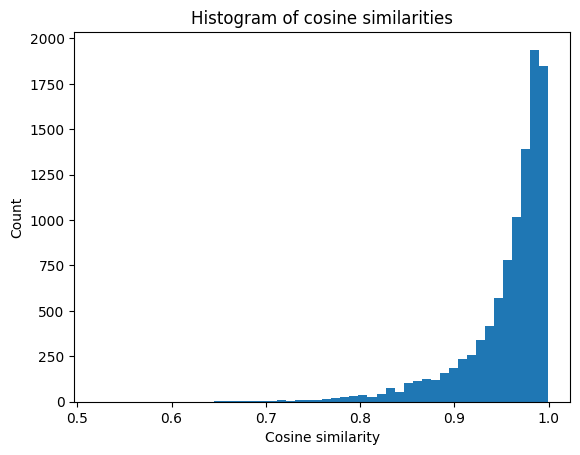

In [10]:
# Transpose and extract all cosine similarities
cosine_similarities_t = np.transpose(cosine_similarities)
cosine_similarities_raw = cosine_similarities_t[0]

# Plot the histogram
plt.hist(cosine_similarities_raw, bins=50)
plt.xlabel('Cosine similarity')
plt.ylabel('Count')
plt.title('Histogram of cosine similarities')
plt.show()

In [11]:
# Create emply list for genuine and imposter scores
genuine_scores = []
imposter_scores = []

# Populate the lists based on true labels provided
for i in range(cosine_similarities.shape[0]):
    if cosine_similarities[i][1] == 1:
        genuine_scores.append(cosine_similarities[i][0])
    else:
        imposter_scores.append(cosine_similarities[i][0])

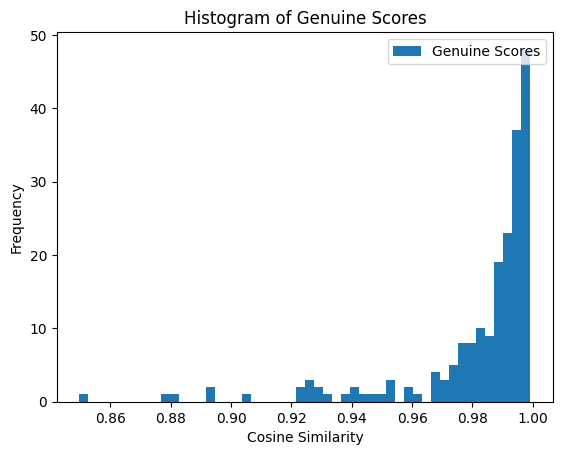

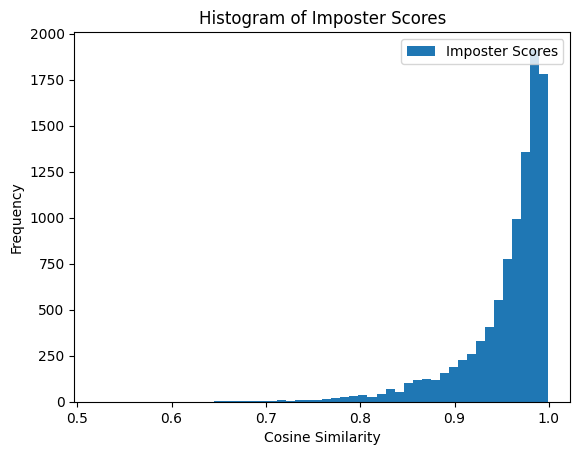

In [12]:
# Plot histogram for genuine_scores
plt.hist(genuine_scores, bins=50, label='Genuine Scores')
plt.title('Histogram of Genuine Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Plot histogram for imposter_scores
plt.hist(imposter_scores, bins=50, label='Imposter Scores')
plt.title('Histogram of Imposter Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

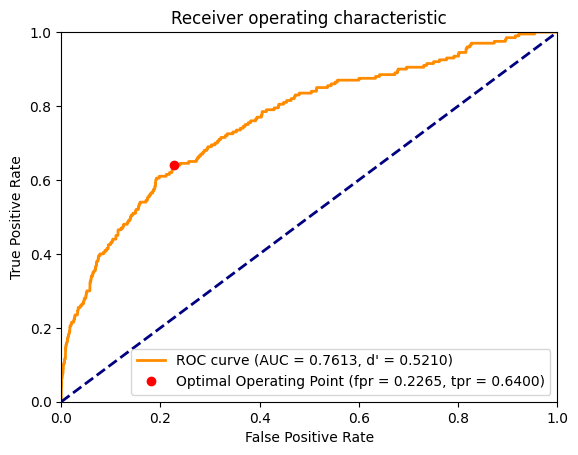

In [13]:
# create arrays to store true labels and similarity scores
true_labels = cosine_similarities_t[1]
scores = cosine_similarities_t[0]

# create arrays to store FPR and TPR for different thresholds
fpr = []
tpr = []
thresholds = []

# calculate the FPR and TPR for different thresholds
fpr, tpr, thresholds = roc_curve(true_labels, scores)

# calculate the area under the ROC curve (AUC)
auc_score = auc(fpr, tpr)

# calculate d prime
d_prime = np.abs(np.mean(scores[true_labels == 1]) - np.mean(scores[true_labels == 0])) / np.sqrt(0.5 * (np.std(scores[true_labels == 1]) ** 2 + np.std(scores[true_labels == 0]) ** 2))

# Calculate the optimal operating point on the ROC curve
optimal_idx = np.argmax(tpr - fpr)
OPTROCPT = (fpr[optimal_idx], tpr[optimal_idx])

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f, d\' = %0.4f)' % (auc_score, d_prime))
plt.plot(OPTROCPT[0], OPTROCPT[1], 'ro', label='Optimal Operating Point (fpr = %0.4f, tpr = %0.4f)' % (fpr[optimal_idx], tpr[optimal_idx]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [14]:
original_data = cosine_similarities

# Define parameters
gallery_size = 200  # Number of rows to include for each probe
probe_size = 50  # Total number of probes (rows in the new object)

# Initialize the new object for the rank1 and rank5 identification calculations
cosine_similarities_probes = np.empty((probe_size, gallery_size, 2))

# Loop through the chunks
for i in range(probe_size):
    # Extract the corresponding chunk of rows from the original dataset
    start_index = i * gallery_size
    end_index = start_index + gallery_size
    chunk = original_data[start_index:end_index, :]

    # Sort the chunk based on the first column in descending order
    sorted_chunk = chunk[chunk[:, 0].argsort()[::-1]]

    # Store the sorted chunk in the new object
    cosine_similarities_probes[i] = sorted_chunk

# Print the new object
print(cosine_similarities_probes)
print(cosine_similarities_probes.shape)

[[[0.99873084 0.        ]
  [0.99843401 0.        ]
  [0.99839449 0.        ]
  ...
  [0.79676086 0.        ]
  [0.70563    0.        ]
  [0.67561495 0.        ]]

 [[0.99852604 0.        ]
  [0.99831593 0.        ]
  [0.9980408  0.        ]
  ...
  [0.80375898 0.        ]
  [0.71280944 0.        ]
  [0.68357146 0.        ]]

 [[0.99796569 0.        ]
  [0.99764335 0.        ]
  [0.99756992 0.        ]
  ...
  [0.81068146 0.        ]
  [0.72273338 0.        ]
  [0.69157279 0.        ]]

 ...

 [[0.9981389  1.        ]
  [0.99794191 0.        ]
  [0.99770689 0.        ]
  ...
  [0.84931546 0.        ]
  [0.76498139 0.        ]
  [0.74002254 0.        ]]

 [[0.9971686  0.        ]
  [0.99678552 0.        ]
  [0.99639165 0.        ]
  ...
  [0.87040675 0.        ]
  [0.82879907 0.        ]
  [0.79481399 0.        ]]

 [[0.99861813 0.        ]
  [0.99830443 0.        ]
  [0.9983021  0.        ]
  ...
  [0.84593242 0.        ]
  [0.75999165 0.        ]
  [0.73442757 0.        ]]]
(50, 200, 

In [15]:
# Initialize the new object for the rank1 and rank5 identifications
rank1_identification = np.zeros(50)
rank5_identification = np.zeros(50)

# Initialize the new object for the rank1 and rank5 identifications using the optimal threshhold
rank1_identification_withThreshold = np.zeros(50)
rank5_identification_withThreshold = np.zeros(50)

# Iterate through the first axis of cosine_similarities_probes
for i in range(50):
    # Select the first element and retrieve the label of that selection
    rank1_identification[i] = (cosine_similarities_probes[i][0][1])

    # Iterate through the second axis of cosine_similarities_probes
    for j in range(5):
        # Retrieve the positive label if there is one
        if cosine_similarities_probes[i][j][1] == 1:
            rank5_identification[i] = (cosine_similarities_probes[i][j][1])

# Setting the threshhold for new rank1 and rank5 identifications
optimal_threshhold = fpr[optimal_idx]

# Iterate through the first axis of cosine_similarities_probes
for i in range(50):
    if optimal_threshhold < cosine_similarities_probes[i][0][0]:
        if cosine_similarities_probes[i][0][1] == 1:
            # Select the first element and retrieve the similarity score of that selection
            rank1_identification_withThreshold[i] = (cosine_similarities_probes[i][0][1])

    # Checking if all top 5 scores are above the optimal threshhold
    if optimal_threshhold < cosine_similarities_probes[i][4][0]:
        # Iterate through the second axis of cosine_similarities_probes
        for j in range(5):
            # Retrieve the positive label if there is one
            if cosine_similarities_probes[i][j][1] == 1:
                rank5_identification_withThreshold[i] = (cosine_similarities_probes[i][j][1])

# Calculating the identification rates
rank1_identification_rate = np.mean(rank1_identification)
rank5_identification_rate = np.mean(rank5_identification)
rank1_identification_withThreshold_rate = np.mean(rank1_identification_withThreshold)
rank5_identification_withThreshold_rate = np.mean(rank5_identification_withThreshold)

print(rank1_identification)
print(rank5_identification)
print(rank1_identification_withThreshold)
print(rank5_identification_withThreshold)

print(rank1_identification_rate)
print(rank5_identification_rate)
print(rank1_identification_withThreshold_rate)
print(rank5_identification_withThreshold_rate)

[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 0.]
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 1.]
[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 0.]
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 1.]
0.46
0.62
0.46
0.62


In [ ]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # rotate images by up to 20 degrees
    width_shift_range=0.2,  # shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # shift images vertically by up to 20% of the image height
    shear_range=0.2,  # apply shear transformation with a shear angle of up to 20 degrees
    zoom_range=0.2,  # apply zoom transformation by up to 20%
    horizontal_flip=True,  # flip images horizontally
    fill_mode='nearest'  # fill any gaps created by the above transformations with the nearest pixel
)
val_datagen = ImageDataGenerator(
    rescale=1./255
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (227,227),
    batch_size=64,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (227,227),
    batch_size=64,
    class_mode='categorical')

Found 350 images belonging to 50 classes.
Found 150 images belonging to 50 classes.


In [16]:
# Load VGG19 model without top layers
base_model = VGG19(weights='imagenet', include_top=False)

# Add top layers
x = base_model.output
x1 = GlobalAveragePooling2D()(x)
x2 = Dense(4096, activation='relu')(x1) # Keep the fully connected layer with 4096 units
x3 = Dense(4096, activation='relu')(x2) # Keep the fully connected layer with 4096 units
predictions = Dense(50, activation='softmax')(x3) # Change to 50 units for 50-class classifier

# Create a new model with the added top layers
model_2 = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
# Train the model
history2_1 = model_2.fit(
    train_generator,
    epochs=20,  # specify the number of epochs for training
    validation_data=val_generator
)

Epoch 1/20
6/6 [==============================] - 361s 63s/step - loss: 4.7056 - accuracy: 0.0086 - val_loss: 3.9271 - val_accuracy: 0.0600
Epoch 2/20
6/6 [==============================] - 358s 63s/step - loss: 3.9366 - accuracy: 0.0171 - val_loss: 3.9015 - val_accuracy: 0.0200
Epoch 3/20
6/6 [==============================] - 389s 73s/step - loss: 3.9118 - accuracy: 0.0286 - val_loss: 3.8820 - val_accuracy: 0.0400
Epoch 4/20
6/6 [==============================] - 389s 73s/step - loss: 3.8794 - accuracy: 0.0571 - val_loss: 3.8410 - val_accuracy: 0.0733
Epoch 5/20
6/6 [==============================] - 352s 61s/step - loss: 3.8266 - accuracy: 0.0600 - val_loss: 3.7607 - val_accuracy: 0.0733
Epoch 6/20
6/6 [==============================] - 395s 70s/step - loss: 3.7113 - accuracy: 0.0686 - val_loss: 3.5992 - val_accuracy: 0.0800
Epoch 7/20
6/6 [==============================] - 388s 68s/step - loss: 3.5540 - accuracy: 0.1057 - val_loss: 3.4097 - val_accuracy: 0.1267
Epoch 8/20
6/6 [====

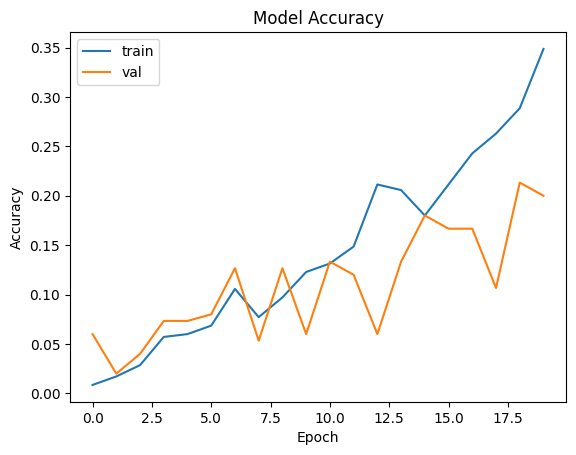

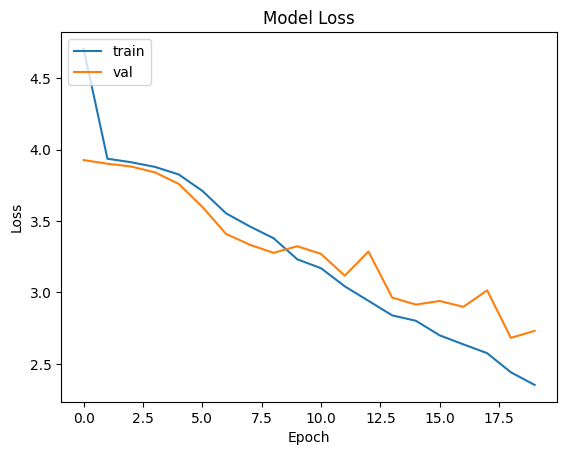

In [ ]:
# Plot the training and validation accuracy
plt.plot(history2_1.history['accuracy'])
plt.plot(history2_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history2_1.history['loss'])
plt.plot(history2_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_2.save_weights('model_2_weights.h5')

In [ ]:
model_2.save('model_2.h5')

In [17]:
# Load the model from the H5 file
model_2.load_weights('/content/model_2_weights.h5')

In [27]:
# Create a new model that outputs the fc7 features
fc7_layer = model_2.get_layer('dense_4')
fc7_output = fc7_layer.output
model_2_withoudHead = Model(inputs=model_2.input, outputs=fc7_output)

In [28]:
# Define the paths to the validation dataset
test_dir = '/content/process_data/test'

# Define the batch size for validation data
batch_size = 1

# Create an empty list to hold the feature vectors for the validation images
test_features2 = []

# Loop through the validation image directories
for folder_name in os.listdir(test_dir):

    test_directory = os.path.join(test_dir, folder_name)

    # Create an empty list to hold the feature vectors for the validation images in the current directory
    directory_features = []
    
    # Loop through the validation images in the current directory
    for i in range(11, 16):
        # Load the validation image using PIL
        img_path = os.path.join(test_directory, f'{folder_name}_{i}.jpg')
        img = image.load_img(img_path, target_size=(227, 227))
        
        # Convert the image to a numpy array and preprocess it
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        # Extract the features using the VGG19 model
        features = model_2_withoudHead.predict(x)
        
        # Add the features to the list of features for the current directory
        directory_features.append(features.flatten())
    
    # Convert the list of features for the current directory to a numpy array
    directory_features = np.array(directory_features)
    
    # Add the numpy array to the list of feature vectors for all validation images
    test_features2.append(directory_features)

# Convert the list of feature vectors for all validation images to a numpy array
test_features2 = np.array(test_features2)
print(test_features2)

1/1 [==============================] - 1s 654ms/step
[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.36846513 0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.90180546 0.         ... 0.         0.         0.        ]
  [0.         0.6866916  0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         1.8151821  0.         ... 0.         0.         0.        ]
  [0.         0.9168182  0.         ... 0.         0.  

In [18]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255
)
val_datagen = ImageDataGenerator(
    rescale=1./255
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (227,227),
    batch_size=64,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (227,227),
    batch_size=64,
    class_mode='categorical')

Found 350 images belonging to 50 classes.
Found 150 images belonging to 50 classes.


In [19]:
# Load VGG19 model without top layers
base_model = VGG19(weights='imagenet', include_top=False)

# Add top layers
x = base_model.output
x1 = GlobalAveragePooling2D()(x)
x2 = Dense(4096, activation='relu')(x1) # Keep the fully connected layer with 4096 units
x3 = Dense(4096, activation='relu')(x2) # Keep the fully connected layer with 4096 units
predictions = Dense(50, activation='softmax')(x3) # Change to 50 units for 50-class classifier

# Create a new model with the added top layers
model_3 = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [20]:
# Train the model
history_3_1 = model_3.fit(
    train_generator,
    epochs=20,  # specify the number of epochs for training
    validation_data=val_generator
)

Epoch 1/20
6/6 [==============================] - 387s 68s/step - loss: 4.5408 - accuracy: 0.0114 - val_loss: 3.9132 - val_accuracy: 0.0333
Epoch 2/20
6/6 [==============================] - 385s 68s/step - loss: 3.9181 - accuracy: 0.0257 - val_loss: 3.8848 - val_accuracy: 0.0467
Epoch 3/20
6/6 [==============================] - 379s 67s/step - loss: 3.8693 - accuracy: 0.0629 - val_loss: 3.8268 - val_accuracy: 0.1000
Epoch 4/20
6/6 [==============================] - 385s 67s/step - loss: 3.7731 - accuracy: 0.0886 - val_loss: 3.7000 - val_accuracy: 0.0800
Epoch 5/20
6/6 [==============================] - 380s 67s/step - loss: 3.5886 - accuracy: 0.1114 - val_loss: 3.5037 - val_accuracy: 0.1133
Epoch 6/20
6/6 [==============================] - 336s 63s/step - loss: 3.3741 - accuracy: 0.1229 - val_loss: 3.3142 - val_accuracy: 0.1267
Epoch 7/20
6/6 [==============================] - 377s 71s/step - loss: 3.1539 - accuracy: 0.1400 - val_loss: 3.2029 - val_accuracy: 0.1933
Epoch 8/20
6/6 [====

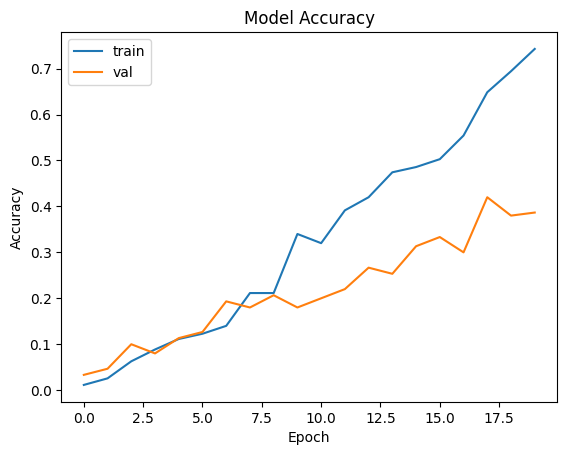

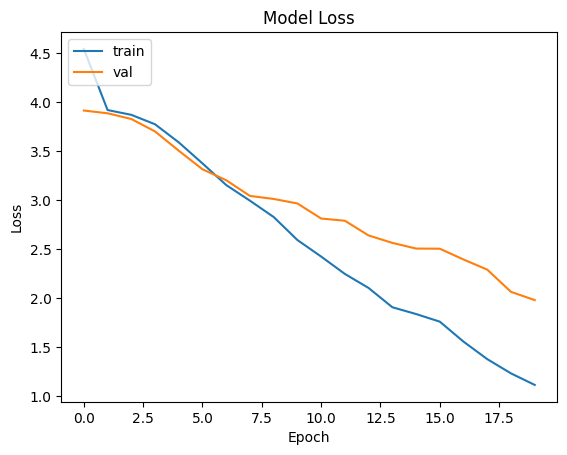

In [21]:
# Plot the training and validation accuracy
plt.plot(history_3_1.history['accuracy'])
plt.plot(history_3_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_3_1.history['loss'])
plt.plot(history_3_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
model_3.save_weights('model_3_weights.h5')

In [23]:
model_3.save('model_3.h5')

In [ ]:
# Load the model from the H5 file
model_3.load_weights('/content/model_3_weights.h5')

In [24]:
# Create a new model that outputs the fc7 features
fc7_layer = model_3.get_layer('dense_7')
fc7_output = fc7_layer.output
model_3_withoudHead = Model(inputs=model_3.input, outputs=fc7_output)

In [26]:
# Define the paths to the validation dataset
test_dir = '/content/process_data/test'

# Define the batch size for validation data
batch_size = 1

# Create an empty list to hold the feature vectors for the validation images
test_features3 = []

# Loop through the validation image directories
for folder_name in os.listdir(test_dir):

    test_directory = os.path.join(test_dir, folder_name)

    # Create an empty list to hold the feature vectors for the validation images in the current directory
    directory_features = []
    
    # Loop through the validation images in the current directory
    for i in range(11, 16):
        # Load the validation image using PIL
        img_path = os.path.join(test_directory, f'{folder_name}_{i}.jpg')
        img = image.load_img(img_path, target_size=(227, 227))
        
        # Convert the image to a numpy array and preprocess it
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        # Extract the features using the VGG19 model
        features = model_3_withoudHead.predict(x)
        
        # Add the features to the list of features for the current directory
        directory_features.append(features.flatten())
    
    # Convert the list of features for the current directory to a numpy array
    directory_features = np.array(directory_features)
    
    # Add the numpy array to the list of feature vectors for all validation images
    test_features3.append(directory_features)

# Convert the list of feature vectors for all validation images to a numpy array
test_features3 = np.array(test_features3)
print(test_features3)

1/1 [==============================] - 1s 629ms/step
[[[0.         0.         5.8425794  ... 0.         0.         5.759424  ]
  [0.         0.         4.1405497  ... 0.         0.         3.165495  ]
  [0.         0.         4.9139647  ... 0.         0.         2.4369574 ]
  [0.         0.         2.6573274  ... 0.         0.         3.3722765 ]
  [0.         0.         4.929103   ... 0.         0.         3.2213151 ]]

 [[0.         0.         3.4174056  ... 0.         0.         3.6706314 ]
  [0.         0.         6.598283   ... 0.         0.         4.1776195 ]
  [0.         0.         5.444682   ... 0.         2.320658   0.        ]
  [0.         0.         6.518884   ... 0.         1.0204501  1.6027808 ]
  [0.         0.         4.6642356  ... 0.         0.07766781 2.706942  ]]

 [[0.         0.         2.9137464  ... 0.         1.2121643  2.0550025 ]
  [0.         0.         6.5099177  ... 0.         5.368968   0.        ]
  [0.         0.         5.3355403  ... 0.         5.05

In [30]:
# Calculate the elementwise average
average_features = np.mean([test_features, test_features2, test_features3], axis=0)

print(average_features.shape)
print(average_features)

(50, 5, 4096)
[[[0.         4.713218   2.7642715  ... 0.         0.         1.919808  ]
  [0.         4.0967665  2.114869   ... 0.         0.         1.0551649 ]
  [0.         3.901858   2.85447    ... 0.         0.         0.8123191 ]
  [0.         3.1763504  1.4915842  ... 0.         0.         1.1240922 ]
  [0.         4.1090846  2.4074576  ... 0.         0.         1.0737717 ]]

 [[0.         4.312464   1.865963   ... 0.         0.         1.2235438 ]
  [0.         5.7185884  3.7399063  ... 0.         0.         1.3925399 ]
  [0.         5.6229606  3.68168    ... 0.         0.77355266 0.        ]
  [0.         5.3756275  4.008633   ... 0.         0.34015003 0.5342603 ]
  [0.         4.6479864  2.6824112  ... 0.         0.02588927 0.902314  ]]

 [[0.         3.6396341  1.74167    ... 0.         0.40405476 0.68500084]
  [0.         4.880298   3.7578182  ... 0.         1.789656   0.        ]
  [0.         3.9934275  2.9198897  ... 0.         1.6858162  0.        ]
  [0.         3.9235

In [31]:
# Create a list for enrollment features for all subjects
enrollment_features = [[0] * 4096 for i in range(50)]

# Create a list for verification features for all subjects and each verification image
verification_features = [[[0] * 4096 for k in range(4)] for j in range(50)]

# Populate the enrollment_features list
for i in range(0,50):
    enrollment_features[i] = average_features[i][0]

# Populate the verification_features list
for j in range(0,50):
    verification_features[j][0] = average_features[j][1]
    verification_features[j][1] = average_features[j][2]
    verification_features[j][2] = average_features[j][3]
    verification_features[j][3] = average_features[j][4]

# Create a numpy array to store the cosine similarities
cosine_similarities_avg = np.zeros((10000, 2))

# Iterate over each person and their enrollment and verification images
for i in range(0,50):
    a = 200 * i
    for j in range(0,50):
        b = a + (4 * j)
        
        # Get the enrollment feature and the four verification features
        enrollment_features_2d = enrollment_features[i].reshape(1, -1)
        verification_features_1_2d = verification_features[j][0].reshape(1, -1)
        verification_features_2_2d = verification_features[j][1].reshape(1, -1)
        verification_features_3_2d = verification_features[j][2].reshape(1, -1)
        verification_features_4_2d = verification_features[j][3].reshape(1, -1)
        # Calculate the cosine similarity between the enrollment and verification features
        cosine_similarities_avg[b][0] = cosine_similarity(enrollment_features_2d, verification_features_1_2d)
        cosine_similarities_avg[b+1][0] = cosine_similarity(enrollment_features_2d, verification_features_2_2d)
        cosine_similarities_avg[b+2][0] = cosine_similarity(enrollment_features_2d, verification_features_3_2d)
        cosine_similarities_avg[b+3][0] = cosine_similarity(enrollment_features_2d, verification_features_4_2d)
        # Set the cosine similarity to 1 if the enrollment and verification images are from the same person
        if i == j:
            cosine_similarities_avg[b][1] = 1
            cosine_similarities_avg[b+1][1] = 1
            cosine_similarities_avg[b+2][1] = 1
            cosine_similarities_avg[b+3][1] = 1

print(cosine_similarities_avg)
print(cosine_similarities_avg.shape)

[[0.99355602 1.        ]
 [0.98254967 1.        ]
 [0.99263692 1.        ]
 ...
 [0.9961496  1.        ]
 [0.99550915 1.        ]
 [0.99481201 1.        ]]
(10000, 2)


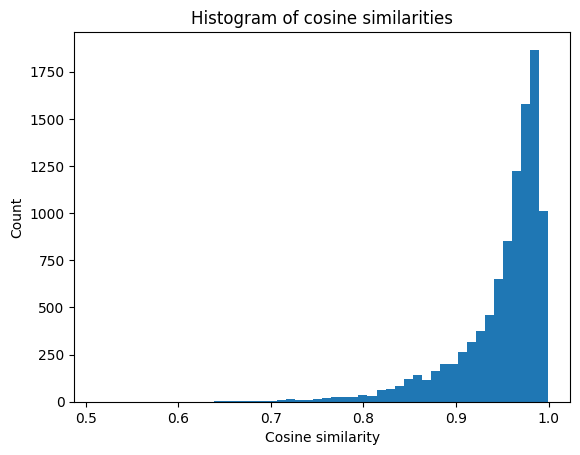

In [32]:
# Transpose and extract all cosine similarities
cosine_similarities_t = np.transpose(cosine_similarities_avg)
cosine_similarities_raw = cosine_similarities_t[0]

# Plot the histogram
plt.hist(cosine_similarities_raw, bins=50)
plt.xlabel('Cosine similarity')
plt.ylabel('Count')
plt.title('Histogram of cosine similarities')
plt.show()

In [33]:
# Create emply list for genuine and imposter scores
genuine_scores = []
imposter_scores = []

# Populate the lists based on true labels provided
for i in range(cosine_similarities_avg.shape[0]):
    if cosine_similarities_avg[i][1] == 1:
        genuine_scores.append(cosine_similarities_avg[i][0])
    else:
        imposter_scores.append(cosine_similarities_avg[i][0])

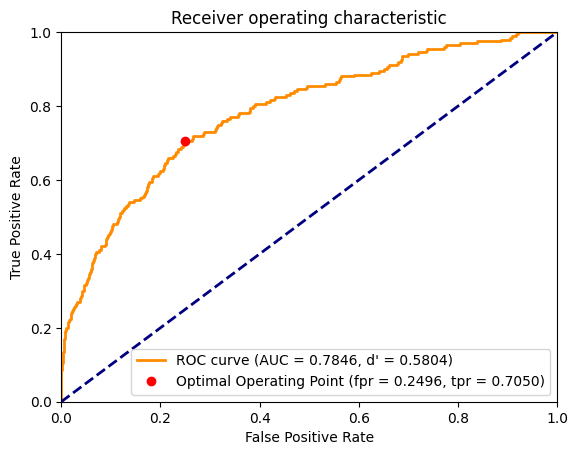

In [34]:
# create arrays to store true labels and similarity scores
true_labels = cosine_similarities_t[1]
scores = cosine_similarities_t[0]

# create arrays to store FPR and TPR for different thresholds
fpr = []
tpr = []
thresholds = []

# calculate the FPR and TPR for different thresholds
fpr, tpr, thresholds = roc_curve(true_labels, scores)

# calculate the area under the ROC curve (AUC)
auc_score = auc(fpr, tpr)

# calculate d prime
d_prime = np.abs(np.mean(scores[true_labels == 1]) - np.mean(scores[true_labels == 0])) / np.sqrt(0.5 * (np.std(scores[true_labels == 1]) ** 2 + np.std(scores[true_labels == 0]) ** 2))

# Calculate the optimal operating point on the ROC curve
optimal_idx = np.argmax(tpr - fpr)
OPTROCPT = (fpr[optimal_idx], tpr[optimal_idx])

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f, d\' = %0.4f)' % (auc_score, d_prime))
plt.plot(OPTROCPT[0], OPTROCPT[1], 'ro', label='Optimal Operating Point (fpr = %0.4f, tpr = %0.4f)' % (fpr[optimal_idx], tpr[optimal_idx]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

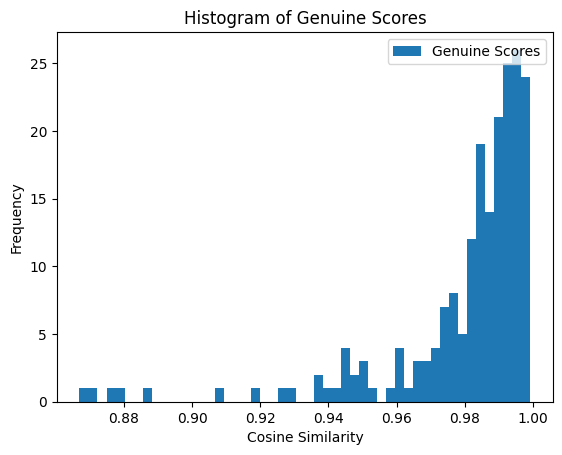

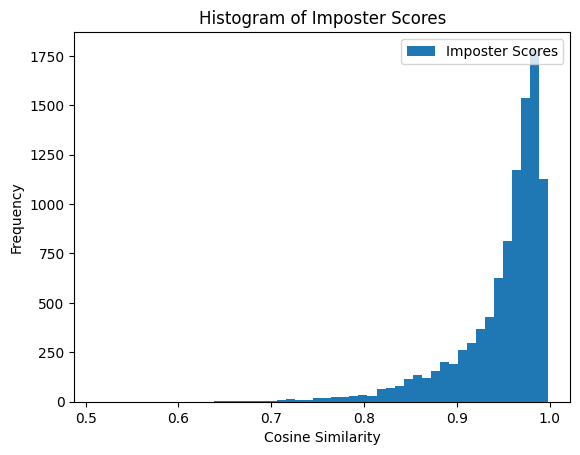

In [35]:
# Plot histogram for genuine_scores
plt.hist(genuine_scores, bins=50, label='Genuine Scores')
plt.title('Histogram of Genuine Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Plot histogram for imposter_scores
plt.hist(imposter_scores, bins=50, label='Imposter Scores')
plt.title('Histogram of Imposter Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [3]:
# Define paths
original_dir = '/content/data/cropped_faces'
train_dir_independent = '/content/process_data_independant/train'
val_dir_independent = '/content/process_data_independant/validation'
test_dir_independent = '/content/process_data_independant/test'

# Create train and validation folders
os.makedirs(train_dir_independent, exist_ok=True)
os.makedirs(val_dir_independent, exist_ok=True)
os.makedirs(test_dir_independent, exist_ok=True)

# Define the number of images to put in each split
train_count = 40
test_count = 10

# Loop through each person
for i in range(1, 51):
    person = "s{:02d}".format(i)
    
    if i <= train_count:
        os.makedirs(os.path.join(train_dir_independent, person), exist_ok=True)
        os.makedirs(os.path.join(val_dir_independent, person), exist_ok=True)
        for j in range(1, 11):
            image_name = "{}_{:02d}.jpg".format(person, j)
            source_path = os.path.join(original_dir, image_name)
            dest_path = os.path.join(train_dir_independent, person, image_name)
            shutil.copy(source_path, dest_path)
        for j in range(11, 16):
            image_name = "{}_{:02d}.jpg".format(person, j)
            source_path = os.path.join(original_dir, image_name)
            dest_path = os.path.join(val_dir_independent, person, image_name)
            shutil.copy(source_path, dest_path)
    else:
        os.makedirs(os.path.join(test_dir_independent, person), exist_ok=True)
        for j in range(1, 16):
            image_name = "{}_{:02d}.jpg".format(person, j)
            source_path = os.path.join(original_dir, image_name)
            dest_path = os.path.join(test_dir_independent, person, image_name)
            shutil.copy(source_path, dest_path)

In [4]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # rotate images by up to 20 degrees
    width_shift_range=0.2,  # shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # shift images vertically by up to 20% of the image height
    shear_range=0.2,  # apply shear transformation with a shear angle of up to 20 degrees
    zoom_range=0.2,  # apply zoom transformation by up to 20%
    horizontal_flip=True,  # flip images horizontally
    fill_mode='nearest'  # fill any gaps created by the above transformations with the nearest pixel
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # rotate images by up to 20 degrees
    width_shift_range=0.2,  # shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,  # shift images vertically by up to 20% of the image height
    shear_range=0.2,  # apply shear transformation with a shear angle of up to 20 degrees
    zoom_range=0.2,  # apply zoom transformation by up to 20%
    horizontal_flip=True,  # flip images horizontally
    fill_mode='nearest'  # fill any gaps created by the above transformations with the nearest pixel
)


train_generator = train_datagen.flow_from_directory(
    train_dir_independent,
    target_size = (227,227),
    batch_size=64,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir_independent,
    target_size = (227,227),
    batch_size=64,
    class_mode='categorical')

Found 400 images belonging to 40 classes.
Found 200 images belonging to 40 classes.


In [8]:
# Load VGG19 model without top layers
base_model = VGG19(weights='imagenet', include_top=False)

# Add top layers
x = base_model.output
x1 = GlobalAveragePooling2D()(x)
x2 = Dense(4096, activation='relu')(x1) # Keep the fully connected layer with 4096 units
x3 = Dense(4096, activation='relu')(x2) # Keep the fully connected layer with 4096 units
predictions = Dense(40, activation='softmax')(x3) # Change to 40 units for 40-class classifier

# Create a new model with the added top layers
model_independent = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_independent.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_independent.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [9]:
# Train the model
history_independent_1 = model_independent.fit(
    train_generator,
    epochs=20,  # specify the number of epochs for training
    validation_data=val_generator
)

Epoch 1/20
7/7 [==============================] - 351s 53s/step - loss: 4.2632 - accuracy: 0.0150 - val_loss: 3.6991 - val_accuracy: 0.0350
Epoch 2/20
7/7 [==============================] - 347s 52s/step - loss: 3.7105 - accuracy: 0.0175 - val_loss: 3.6729 - val_accuracy: 0.0400
Epoch 3/20
7/7 [==============================] - 309s 46s/step - loss: 3.6773 - accuracy: 0.0350 - val_loss: 3.6375 - val_accuracy: 0.0500
Epoch 4/20
7/7 [==============================] - 305s 45s/step - loss: 3.6142 - accuracy: 0.0600 - val_loss: 3.5443 - val_accuracy: 0.0950
Epoch 5/20
7/7 [==============================] - 351s 52s/step - loss: 3.5043 - accuracy: 0.0725 - val_loss: 3.3734 - val_accuracy: 0.0800
Epoch 6/20
7/7 [==============================] - 345s 52s/step - loss: 3.3692 - accuracy: 0.0925 - val_loss: 3.2912 - val_accuracy: 0.0800
Epoch 7/20
7/7 [==============================] - 344s 52s/step - loss: 3.2618 - accuracy: 0.0775 - val_loss: 3.2191 - val_accuracy: 0.0800
Epoch 8/20
7/7 [====

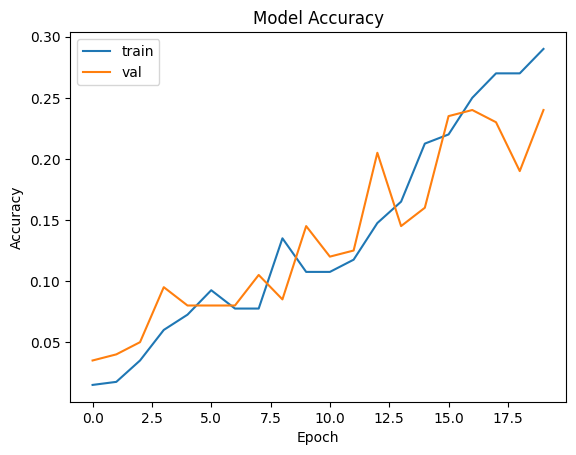

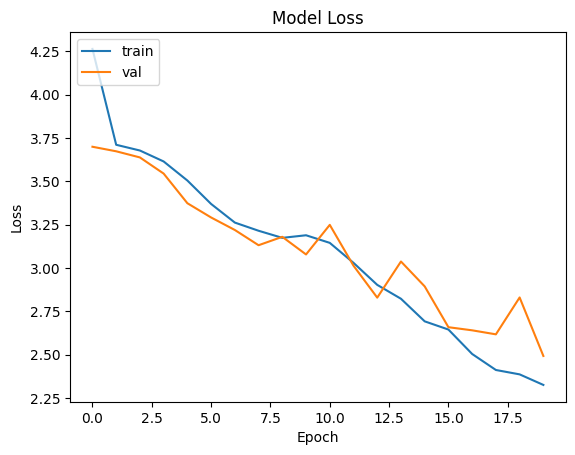

In [10]:
# Plot the training and validation accuracy
plt.plot(history_independent_1.history['accuracy'])
plt.plot(history_independent_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history_independent_1.history['loss'])
plt.plot(history_independent_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
model_independent.save_weights('model_independent_weights.h5')

In [12]:
model_independent.save('model_independent.h5')

In [13]:
# Create a new model that outputs the fc7 features
fc7_layer = model_independent.get_layer('dense_10')
fc7_output = fc7_layer.output
model_independent_withoudHead = Model(inputs=model_independent.input, outputs=fc7_output)

In [18]:
# Define the paths to the validation dataset
test_dir = '/content/process_data_independant/test'

# Define the batch size for validation data
batch_size = 1

# Create an empty list to hold the feature vectors for the validation images
test_features_independent = []

# Loop through the validation image directories
for folder_name in os.listdir(test_dir):

    test_directory = os.path.join(test_dir, folder_name)

    # Create an empty list to hold the feature vectors for the validation images in the current directory
    directory_features = []
    
    # Loop through the validation images in the current directory
    for i in range(1, 16):
        # Load the validation image using PIL
        if i < 10:
            img_path = os.path.join(test_directory, f'{folder_name}_0{i}.jpg')
        else:
            img_path = os.path.join(test_directory, f'{folder_name}_{i}.jpg')
        img = image.load_img(img_path, target_size=(227, 227))
        
        # Convert the image to a numpy array and preprocess it
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        # Extract the features using the VGG19 model
        features = model_independent_withoudHead.predict(x)
        
        # Add the features to the list of features for the current directory
        directory_features.append(features.flatten())
    
    # Convert the list of features for the current directory to a numpy array
    directory_features = np.array(directory_features)
    
    # Add the numpy array to the list of feature vectors for all validation images
    test_features_independent.append(directory_features)

# Convert the list of feature vectors for all validation images to a numpy array
test_features_independent = np.array(test_features_independent)
print(test_features_independent)

1/1 [==============================] - 1s 522ms/step
[[[ 0.          0.          0.         ... 10.54312     0.08582778
    0.        ]
  [ 0.          0.          0.         ...  9.430253    0.5414949
    0.        ]
  [ 0.          0.          0.         ...  9.650424    0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  7.6797814   0.
    0.        ]
  [ 0.          0.          0.         ...  6.4337816   0.12662497
    0.        ]
  [ 0.          0.          0.         ...  7.3891854   0.8449629
    0.        ]]

 [[ 0.          0.          0.         ...  7.0878296   0.
    0.        ]
  [ 0.          0.          0.         ...  6.0864573   0.08150569
    0.        ]
  [ 0.          0.          0.         ...  4.731443    0.
    0.        ]
  ...
  [ 0.          0.          0.         ...  7.2884197   0.
    0.        ]
  [ 0.          0.          0.         ...  8.092626    0.42694688
    0.        ]
  [ 0.          0.          0.         ...  8.013678    0.
   

In [19]:
print(test_features_independent.shape)

(10, 15, 4096)


In [25]:
# Create a list for enrollment features for all subjects
enrollment_features = [[0] * 4096 for i in range(10)]

# Create a list for verification features for all subjects and each verification image
verification_features = [[[0] * 4096 for k in range(14)] for j in range(10)]

# Populate the enrollment_features list
for i in range(0,10):
    enrollment_features[i] = test_features_independent[i][0]

# Populate the verification_features list
for j in range(0,10):
    for i in range(0,14):
        verification_features[j][i] = test_features_independent[j][i+1]

# Create a numpy array to store the cosine similarities
cosine_similarities_independent = np.zeros((1400, 2))

# Iterate over each person and their enrollment and verification images
for i in range(0,10):
    a = 140 * i
    for j in range(0,10):
        b = a + (14 * j)
        enrollment_features_2d = enrollment_features[i].reshape(1, -1)
        for k in range(0,14):
            verification_features_2d = verification_features[j][k].reshape(1, -1)
            cosine_similarities_independent[b+k][0] = cosine_similarity(enrollment_features_2d, verification_features_2d)
        if i == j:
            for k in range(0,14):
                cosine_similarities_independent[b+k][1] = 1


print(cosine_similarities_independent)
print(cosine_similarities_independent.shape)

[[0.99686724 1.        ]
 [0.99397624 1.        ]
 [0.97055191 1.        ]
 ...
 [0.9673363  1.        ]
 [0.96765578 1.        ]
 [0.99450433 1.        ]]
(1400, 2)


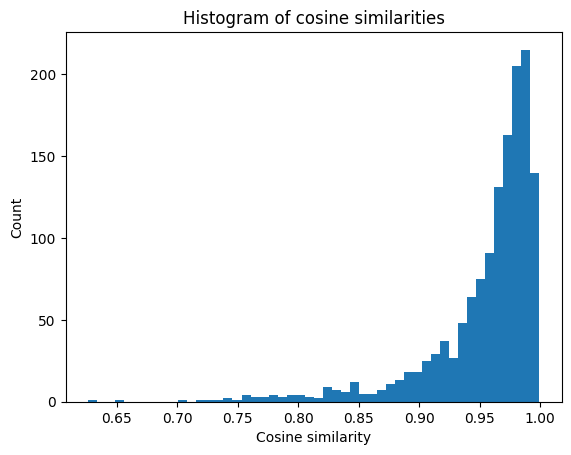

In [27]:
# Transpose and extract all cosine similarities
cosine_similarities_t = np.transpose(cosine_similarities_independent)
cosine_similarities_raw = cosine_similarities_t[0]

# Plot the histogram
plt.hist(cosine_similarities_raw, bins=50)
plt.xlabel('Cosine similarity')
plt.ylabel('Count')
plt.title('Histogram of cosine similarities')
plt.show()

In [28]:
# Create emply list for genuine and imposter scores
genuine_scores = []
imposter_scores = []

# Populate the lists based on true labels provided
for i in range(cosine_similarities_independent.shape[0]):
    if cosine_similarities_independent[i][1] == 1:
        genuine_scores.append(cosine_similarities_independent[i][0])
    else:
        imposter_scores.append(cosine_similarities_independent[i][0])

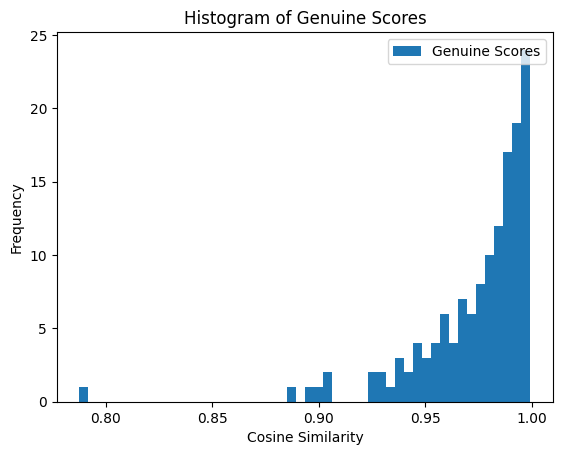

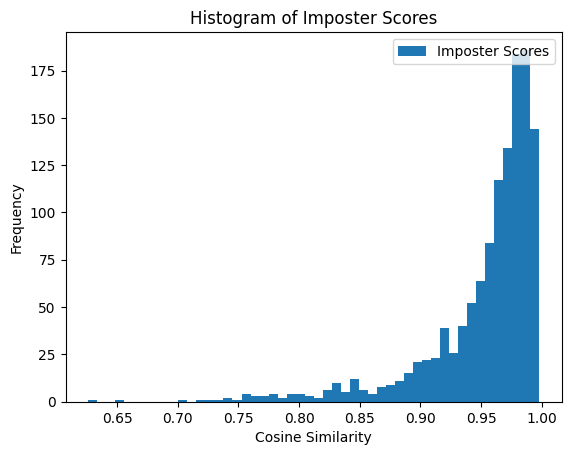

In [30]:
# Plot histogram for genuine_scores
plt.hist(genuine_scores, bins=50, label='Genuine Scores')
plt.title('Histogram of Genuine Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Plot histogram for imposter_scores
plt.hist(imposter_scores, bins=50, label='Imposter Scores')
plt.title('Histogram of Imposter Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

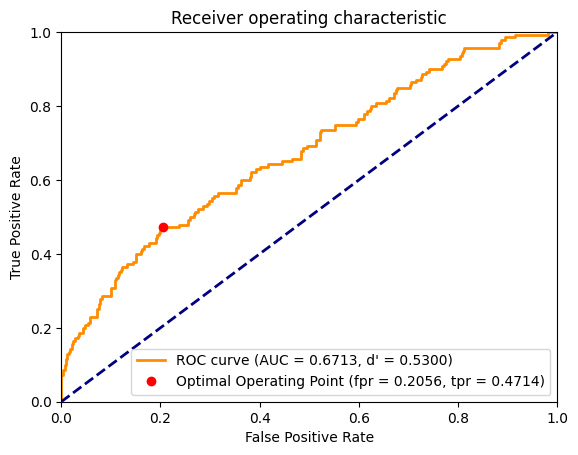

In [29]:
# create arrays to store true labels and similarity scores
true_labels = cosine_similarities_t[1]
scores = cosine_similarities_t[0]

# create arrays to store FPR and TPR for different thresholds
fpr = []
tpr = []
thresholds = []

# calculate the FPR and TPR for different thresholds
fpr, tpr, thresholds = roc_curve(true_labels, scores)

# calculate the area under the ROC curve (AUC)
auc_score = auc(fpr, tpr)

# calculate d prime
d_prime = np.abs(np.mean(scores[true_labels == 1]) - np.mean(scores[true_labels == 0])) / np.sqrt(0.5 * (np.std(scores[true_labels == 1]) ** 2 + np.std(scores[true_labels == 0]) ** 2))

# Calculate the optimal operating point on the ROC curve
optimal_idx = np.argmax(tpr - fpr)
OPTROCPT = (fpr[optimal_idx], tpr[optimal_idx])

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f, d\' = %0.4f)' % (auc_score, d_prime))
plt.plot(OPTROCPT[0], OPTROCPT[1], 'ro', label='Optimal Operating Point (fpr = %0.4f, tpr = %0.4f)' % (fpr[optimal_idx], tpr[optimal_idx]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()